From all mice, look at different onsets of investigations and the associated response

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from experiment_class import Experiment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# NAc: #15616F
# mPFC: #FFAF00

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac_csvs"
# brain_region = '#15616F'

experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc_csvs"
brain_region = '#FFAF00'


save_images = False

trial.remove_initial_LED_artifact(t=30)
trial.remove_final_data_segment(t = 10)

trial.smooth_and_apply(window_len=int(trial.fs)*1)
trial.apply_ma_baseline_drift()
trial.compute_zscore(method = 'standard')
trial.verify_signal()

csv_file_name = f"{trial_folder}.csv"
csv_file_path = os.path.join(self.behavior_folder_path, csv_file_name)
trial.extract_manual_annotation_behaviors(csv_file_path)

In [3]:
experiment = Experiment(experiment_path, csv_base_path)

experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc\pp7-250114-070021\Notes.txt
read from t=0s to t=1353.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc\pp8-250114-080316\Notes.txt
read from t=0s to t=1358.96s
Processing pp7-250114-070021...
Processing pp8-250114-080316...


In [4]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for pp7-250114-070021...
Processing behaviors for pp8-250114-080316...


In [6]:
experiment.compute_all_da_metrics(
    max_bout_duration=4
)

Computing DA metrics for pp7-250114-070021 ...
Computing DA metrics for pp8-250114-080316 ...


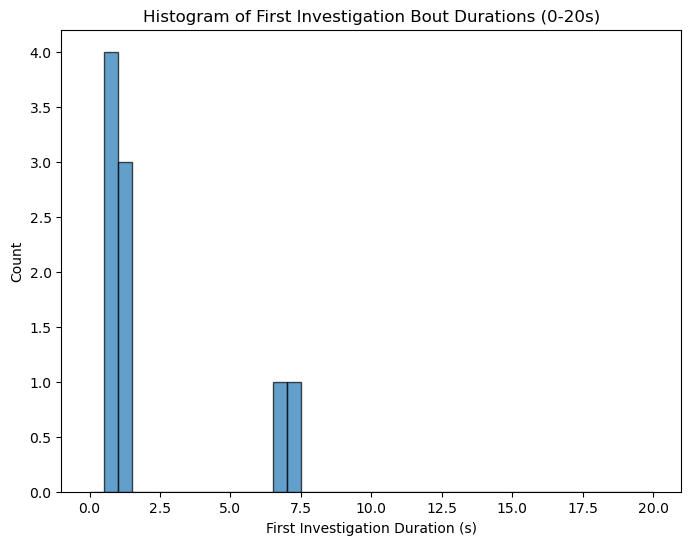

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect first investigation durations from all trials
first_investigation_durations = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        # Filter only the first investigation per bout
        first_investigations = (
            trial.behaviors[trial.behaviors["Behavior"] == "Investigation"]
            .sort_values("Event_Start")
            .groupby("Bout", as_index=False)
            .first()
        )

        # Compute duration
        durations = first_investigations["Event_End"] - first_investigations["Event_Start"]
        first_investigation_durations.extend(durations.tolist())

# Convert to NumPy array for safety and filter between 0-5s
first_investigation_durations = np.array(first_investigation_durations)
filtered_durations = first_investigation_durations
# [
#     (first_investigation_durations >= 0) & (first_investigation_durations <= 5)
# ]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(filtered_durations, bins=40, range=(0, 20), edgecolor='black', alpha=0.7)
plt.xlabel("First Investigation Duration (s)")
plt.ylabel("Count")
plt.title("Histogram of First Investigation Bout Durations (0-20s)")
plt.show()


In [8]:
for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        df = trial.behaviors
        # print(df)
        # Copy old metrics into new columns
        df["OG_AUC"]            = df["AUC"]
        df["OG_Max Peak"]       = df["Max Peak"]
        df["OG_Time of Max Peak"] = df["Time of Max Peak"]
        df["OG_Mean Z-score"]   = df["Mean Z-score"]
        
        # Copy the old end times
        if "Original End" in df.columns:
            df["OG_Original End"] = df["Original End"]
        if "Adjusted End" in df.columns:
            df["OG_Adjusted End"] = df["Adjusted End"]

In [10]:
experiment.compute_all_da_metrics(
)

Computing DA metrics for pp7-250114-070021 ...
Computing DA metrics for pp8-250114-080316 ...


In [11]:
all_changed_rows = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        df = trial.behaviors
        # Identify rows where the new "Adjusted End" differs from the "Original End"
        changed_df = df[df["Adjusted End"] != df["Original End"]].copy()
        
        if not changed_df.empty:
            # Insert subject name (or trial name) in the first column
            changed_df.insert(0, "Subject", trial.subject_name)
            all_changed_rows.append(changed_df)

if all_changed_rows:
    final_changed_df = pd.concat(all_changed_rows, ignore_index=True)
    final_changed_df.to_csv("adjusted_end_changes.csv", index=False)
    print("Saved rows with changed end times (plus original metrics) to adjusted_end_changes.csv")
else:
    print("No adjusted end times differ from the original end times.")

KeyError: 'Original End'

In [ ]:
final_changed_df.head()

,Subject,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,Original End,Adjusted End,OG_AUC,OG_Max Peak,OG_Time of Max Peak,OG_Mean Z-score,OG_Original End,OG_Adjusted End
0,p1,s1-1,Investigation,197.267,225.733,28.466,19.554995,5.778781,200.416293,2.914105,225.733,203.976864,16.077557,5.778781,200.416293,0.564744,225.733,225.733
1,p1,s1-2,Investigation,384.267,387.400,3.133,0.308863,0.407145,385.462756,0.202870,387.400,385.790108,0.314949,0.407145,385.462756,0.100556,387.400,387.400
2,p1,s1-4,Investigation,767.733,768.333,0.600,8.105525,2.430694,769.346749,1.870396,768.333,772.066821,1.145754,2.145404,768.332252,1.913905,768.333,768.333
3,p1,s1-5,Investigation,988.267,988.867,0.600,0.075832,0.317017,988.299244,0.200897,988.867,988.645274,0.075788,0.317017,988.299244,0.126643,988.867,988.867
4,p1,s1-6,Investigation,1171.667,1173.067,1.400,0.043213,0.361675,1171.667658,0.224331,1173.067,1171.860334,-0.703067,0.361675,1171.667658,-0.502363,1173.067,1173.067


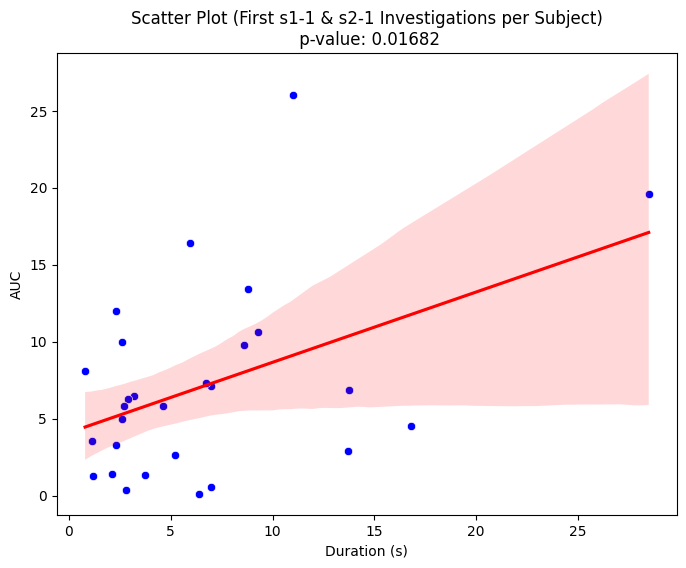

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 1. Filter for Investigation behavior and only Bout == "s1-1" or "s2-1"
df_filtered = final_changed_df[
    (final_changed_df['Behavior'] == 'Investigation') &
    (final_changed_df['Bout'].isin(['s1-1', 's2-1']))
]

# 2. Sort by Subject, Bout, and any time variable (e.g., Event_Start) to ensure 
#    "first" is the earliest
df_filtered = df_filtered.sort_values(['Subject', 'Bout', 'Event_Start'])

# 3. For each (Subject, Bout), keep only the first row
df_filtered = df_filtered.drop_duplicates(subset=['Subject', 'Bout'], keep='first')

# 4. Compute regression statistics
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['Duration (s)'], df_filtered['AUC'])

# 5. Plot the filtered data
plt.figure(figsize=(8,6))

# Scatter plot
sns.scatterplot(data=df_filtered, x='Duration (s)', y='AUC', color='blue')

# Best-fit regression line (omit scatter points here to avoid double-plotting)
sns.regplot(data=df_filtered, x='Duration (s)', y='AUC', scatter=False, color='red')

# Labels and title
plt.xlabel('Duration (s)')
plt.ylabel('AUC')
plt.title(f'Scatter Plot (First s1-1 & s2-1 Investigations per Subject)\n p-value: {p_value:.4g}')

plt.show()


In [ ]:
df_filtered

,Subject,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,...,Adjusted End,OG_AUC,OG_Max Peak,OG_Time of Max Peak,OG_Mean Z-score,OG_Original End,OG_Adjusted End,time_diff,auc_diff,mean_diff
0,p1,s1-1,Investigation,197.267,225.733,28.466,19.554995,5.778781,200.416293,2.914105,...,203.976864,16.077557,5.778781,200.416293,0.564744,225.733,225.733,-21.756136,3.477438,2.349361
5,p1,s2-1,Investigation,1353.200,1361.800,8.600,9.747825,3.274460,1355.591489,2.114003,...,1357.811193,8.670519,3.274460,1355.591489,1.008235,1361.800,1361.800,-3.988807,1.077306,1.105769
6,p2,s1-1,Investigation,197.533,203.467,5.934,16.416473,6.950705,198.645838,5.252516,...,200.658121,16.890415,6.950705,198.645838,2.846415,203.467,203.467,-2.808879,-0.473942,2.406101
12,p2,s2-1,Investigation,1364.667,1378.400,13.733,6.884701,1.864994,1369.862280,0.704895,...,1374.434399,5.195061,1.864994,1369.862280,0.378277,1378.400,1378.400,-3.965601,1.689640,0.326618
13,p3,s1-1,Investigation,184.467,187.067,2.600,9.961393,4.201036,184.510706,2.213580,...,188.967809,7.317707,4.201036,184.510706,2.815436,187.067,187.067,1.900809,2.643686,-0.601856
18,p3,s2-1,Investigation,1353.800,1356.133,2.333,3.294414,1.565270,1357.177133,0.662388,...,1358.773589,0.538997,0.799962,1356.132161,0.231357,1356.133,1356.133,2.640589,2.755416,0.431031
19,p4,s1-1,Investigation,212.000,215.200,3.200,6.465954,2.281877,212.424126,1.576880,...,216.100696,5.729355,2.281877,212.424126,1.790942,215.200,215.200,0.900696,0.736599,-0.214062
26,p4,s2-1,Investigation,1580.667,1584.400,3.733,1.332640,1.582234,1580.667340,1.004189,...,1581.994444,0.247984,1.582234,1580.667340,0.066417,1584.400,1584.400,-2.405556,1.084656,0.937772
27,p5,s1-1,Investigation,187.500,190.300,2.800,0.330143,1.319623,187.500131,0.856733,...,187.885482,0.316178,1.319623,187.500131,0.113071,190.300,190.300,-2.414518,0.013965,0.743662
30,p5,s2-1,Investigation,1143.000,1145.900,2.900,6.247096,1.780937,1145.638725,0.869129,...,1150.187251,2.288216,1.780937,1145.638725,0.789313,1145.900,1145.900,4.287251,3.958880,0.079816


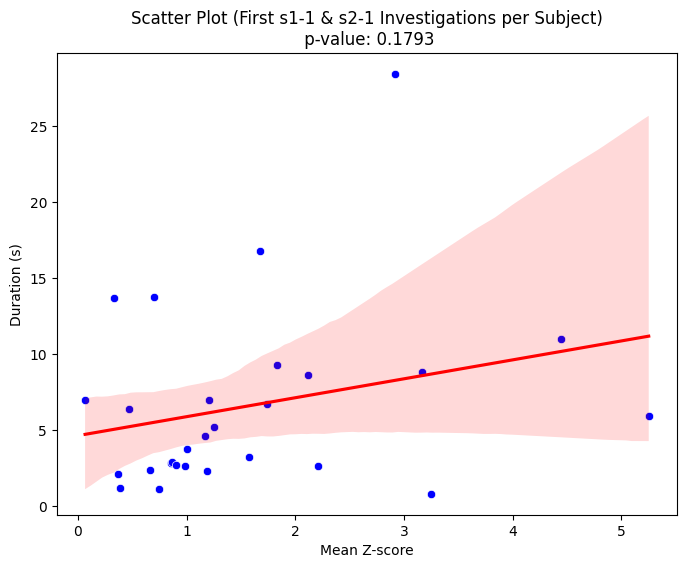

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 1. Filter for Investigation behavior and only Bout == "s1-1" or "s2-1"
df_filtered = final_changed_df[
    (final_changed_df['Behavior'] == 'Investigation') &
    (final_changed_df['Bout'].isin(['s1-1', 's2-1']))
]

# 2. Sort by Subject, Bout, and any time variable (e.g., Event_Start) to ensure 
#    "first" is the earliest
df_filtered = df_filtered.sort_values(['Subject', 'Bout', 'Event_Start'])

# 3. For each (Subject, Bout), keep only the first row
df_filtered = df_filtered.drop_duplicates(subset=['Subject', 'Bout'], keep='first')

# 4. Compute regression statistics
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['Mean Z-score'], df_filtered['Duration (s)'])

# 5. Plot the filtered data
plt.figure(figsize=(8,6))

# Scatter plot
sns.scatterplot(data=df_filtered, x='Mean Z-score', y='Duration (s)', color='blue')

# Best-fit regression line (omit scatter points here to avoid double-plotting)
sns.regplot(data=df_filtered, x='Mean Z-score', y='Duration (s)', scatter=False, color='red')

# Labels and title
plt.xlabel('Mean Z-score')
plt.ylabel('Duration (s)')
plt.title(f'Scatter Plot (First s1-1 & s2-1 Investigations per Subject)\n p-value: {p_value:.4g}')

plt.show()


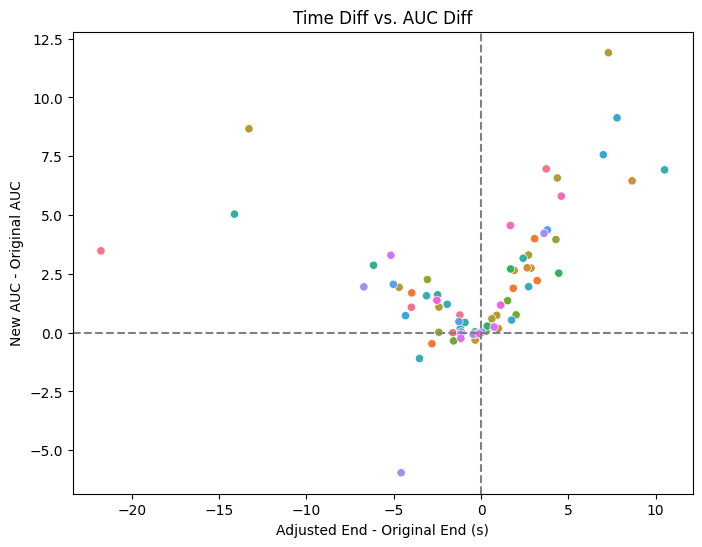

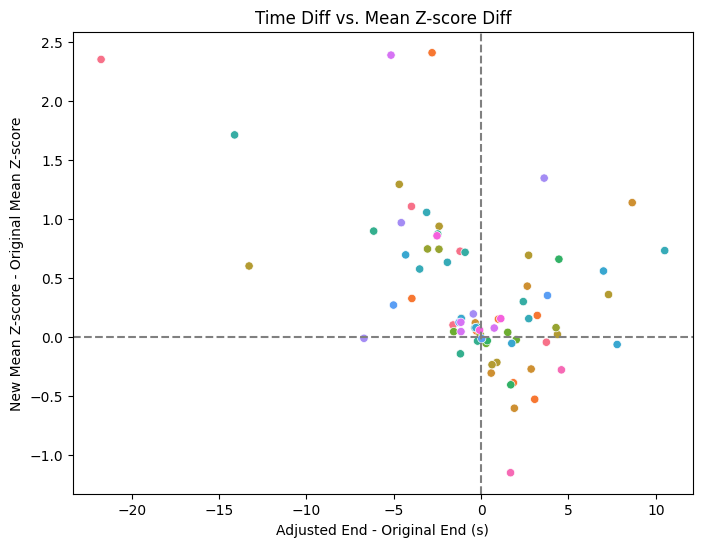

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create difference columns
#    - time_diff < 0 => bout got shorter
#    - time_diff > 0 => bout got longer
final_changed_df["time_diff"] = final_changed_df["Adjusted End"] - final_changed_df["Original End"]
final_changed_df["auc_diff"] = final_changed_df["AUC"] - final_changed_df["OG_AUC"]
final_changed_df["mean_diff"] = final_changed_df["Mean Z-score"] - final_changed_df["OG_Mean Z-score"]

# 2. Plot time_diff vs. auc_diff
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_changed_df, x="time_diff", y="auc_diff", hue="Subject")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Time Diff vs. AUC Diff")
plt.xlabel("Adjusted End - Original End (s)")
plt.ylabel("New AUC - Original AUC")
plt.legend([], [], frameon=False)  # Remove legend

plt.show()

# 3. Plot time_diff vs. mean_diff
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_changed_df, x="time_diff", y="mean_diff", hue="Subject")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Time Diff vs. Mean Z-score Diff")
plt.xlabel("Adjusted End - Original End (s)")
plt.ylabel("New Mean Z-score - Original Mean Z-score")
plt.legend([], [], frameon=False)  # Remove legend

plt.show()


In [ ]:
# Grab associated DA levels for each investigtation. Look at first investigation DA. 
# provides area under the curve, max peak height, max z-scored ΔF/F, and the time at which the max ΔF/F value occurs.

In [ ]:
# Look at DA for super long investigation bouts. See what's up. Look at DA for all investigations. See if there's a difference between the two

In [ ]:
# This is looking at NAc, look at mPFC too

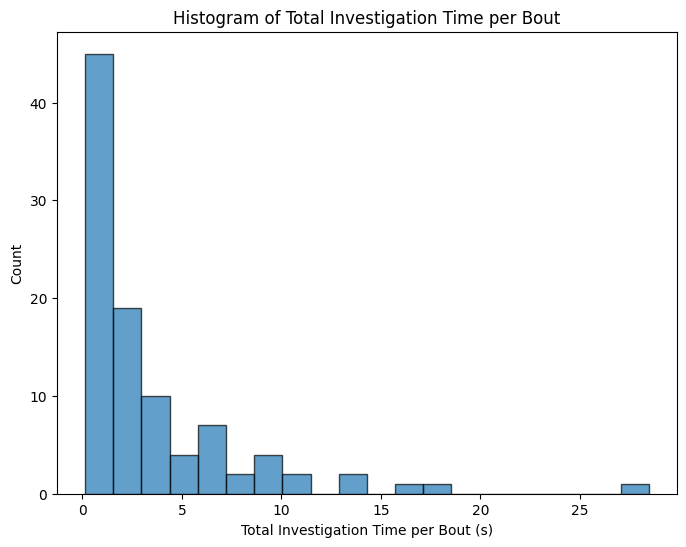

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect investigation data from all trials
investigation_data = []

for trial_name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
        # Add subject information if missing
        if "Subject" not in trial.behaviors.columns:
            trial.behaviors["Subject"] = trial_name  # Assign trial name as Subject

        # Filter only "Investigation" behaviors
        investigation_df = trial.behaviors[trial.behaviors["Behavior"] == "Investigation"].copy()

        # Ensure "Duration (s)" exists, or calculate it
        if "Duration (s)" not in investigation_df.columns:
            investigation_df["Duration (s)"] = investigation_df["Event_End"] - investigation_df["Event_Start"]

        # Group by Subject and Bout to compute total investigation time
        grouped = (
            investigation_df
            .groupby(["Subject", "Bout"], as_index=False)
            .agg(Total_Investigation_Time=("Duration (s)", "sum"))  # Total time spent investigating
        )

        # Append to list
        investigation_data.append(grouped)

# Concatenate results from all trials into one DataFrame
if investigation_data:
    investigation_stats = pd.concat(investigation_data, ignore_index=True)
else:
    investigation_stats = pd.DataFrame(columns=["Subject", "Bout", "Total invest"])

# Extract total investigation time per bout
total_investigation_times = investigation_stats["Total_Investigation_Time"]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(total_investigation_times, bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Total Investigation Time per Bout (s)")
plt.ylabel("Count")
plt.title("Histogram of Total Investigation Time per Bout")
plt.show()
